In [ ]:
pip install transformers pygraphviz

Note: you may need to restart the kernel to use updated packages.


# Load Model

In [1]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# 模型和配置文件会下载到 /Users/roger/.cache/huggingface/hub/models--gpt2/ 目录下
model = GPT2LMHeadModel.from_pretrained('gpt2', use_safetensors=True).to(device)
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model.eval()

text = "Beijing is the capital of"
input_ids = tokenizer.encode(text, return_tensors='pt').to(device)

outputs = model.generate(input_ids, max_length=len(input_ids.squeeze()) + 5)
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(generated_text)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Beijing is the capital of China's second largest economy


# Greedy Search

In [2]:
import networkx as nx
import numpy as np

def get_log_prob(logits, token_id):
    prob = torch.nn.functional.softmax(logits, dim=-1)
    log_prob = torch.log(prob)
    token_log_prob = log_prob[token_id].item()
    return token_log_prob


def greed_search(input_ids, node, length=5):
    if length == 0:
        return input_ids
    outputs = model(input_ids)
    preds = outputs.logits
    logits = preds[0, -1, :]
    token_id = torch.argmax(logits).unsqueeze(0)
    token_score = get_log_prob(logits, token_id)

    new_input_ids = torch.cat((input_ids, token_id.unsqueeze(0)), dim=-1)
    next_token = tokenizer.decode(token_id, skip_special_tokens=True)
    next_node = list(graph.successors(node))[0]
    graph.nodes[next_node]['token'] = next_token + f"_{length}"
    graph.nodes[next_node]['tokenscore'] = np.exp(token_score) * 100

    input_ids = greed_search(new_input_ids, next_node, length=length-1)
    return input_ids
    

length = 5
beams = 1
graph = nx.balanced_tree(1, length, create_using=nx.DiGraph)
graph.nodes[0]['token'] = text
graph.nodes[0]['tokenscore'] = 100

output_ids = greed_search(input_ids, 0, length=length)
output = tokenizer.decode(output_ids.squeeze().tolist(), skip_special_tokens=True)
print(f"Generated text: {output}")
for node in graph.nodes:
    print(node, graph.nodes[node])

Generated text: Beijing is the capital of China's second largest economy
0 {'token': 'Beijing is the capital of', 'tokenscore': 100}
1 {'token': ' China_5', 'tokenscore': np.float64(37.25772476639106)}
2 {'token': "'s_4", 'tokenscore': np.float64(33.363382976101576)}
3 {'token': ' second_3', 'tokenscore': np.float64(12.55846234275839)}
4 {'token': ' largest_2', 'tokenscore': np.float64(46.49423860248157)}
5 {'token': ' economy_1', 'tokenscore': np.float64(49.90957212241315)}


# Beam Search

In [4]:
from tqdm.notebook import tqdm

def greedy_sampling(logits, beams):
    return torch.topk(logits, beams).indices

def beam_search(input_ids, node, bar, length, beams, sampling, temperature=0.1):
    if length == 0:
        return None
    
    outputs = model(input_ids)
    preds = outputs.logits
    logits = preds[0, -1, :]

    if sampling == 'greedy':
        top_token_ids = greedy_sampling(logits, beams)
    elif sampling == 'top_k':
        top_token_ids = top_k_sampling(logits, temperature, 20, beams)
    elif sampling == 'nucleus':
        top_token_ids = nucleus_sampling(logits, temperature, 0.5, beams)
    
    for j, token_id in enumerate(top_token_ids):
        bar.update(1)
        token_score = get_log_prob(logits, token_id)
        cumulative_score = graph.nodes[node]['cumscore'] + token_score
        new_input_ids = torch.cat([input_ids, token_id.unsqueeze(0).unsqueeze(0)], dim=-1)

        token = tokenizer.decode(token_id, skip_special_tokens=True)
        next_node = list(graph.successors(node))[j]
        graph.nodes[next_node]['tokenscore'] = np.exp(token_score) * 100
        graph.nodes[next_node]['cumscore'] = cumulative_score
        graph.nodes[next_node]['sequencescore'] = 1 / len(new_input_ids.squeeze()) * cumulative_score
        graph.nodes[next_node]['token'] = token + f"_{length}_{j}"

        beam_search(new_input_ids, next_node, bar, length - 1, beams, sampling, 1)
    
length = 5
beams = 2
graph = nx.balanced_tree(beams, length, create_using=nx.DiGraph)
bar = tqdm(total=len(graph.nodes))

for node in graph.nodes:
    graph.nodes[node]['tokenscore'] = 100
    graph.nodes[node]['cumscore'] = 0
    graph.nodes[node]['sequencescore'] = 0
    graph.nodes[node]['token'] = text

beam_search(input_ids, 0, bar, length, beams, 'greedy', 1)


  0%|          | 0/63 [00:00<?, ?it/s]

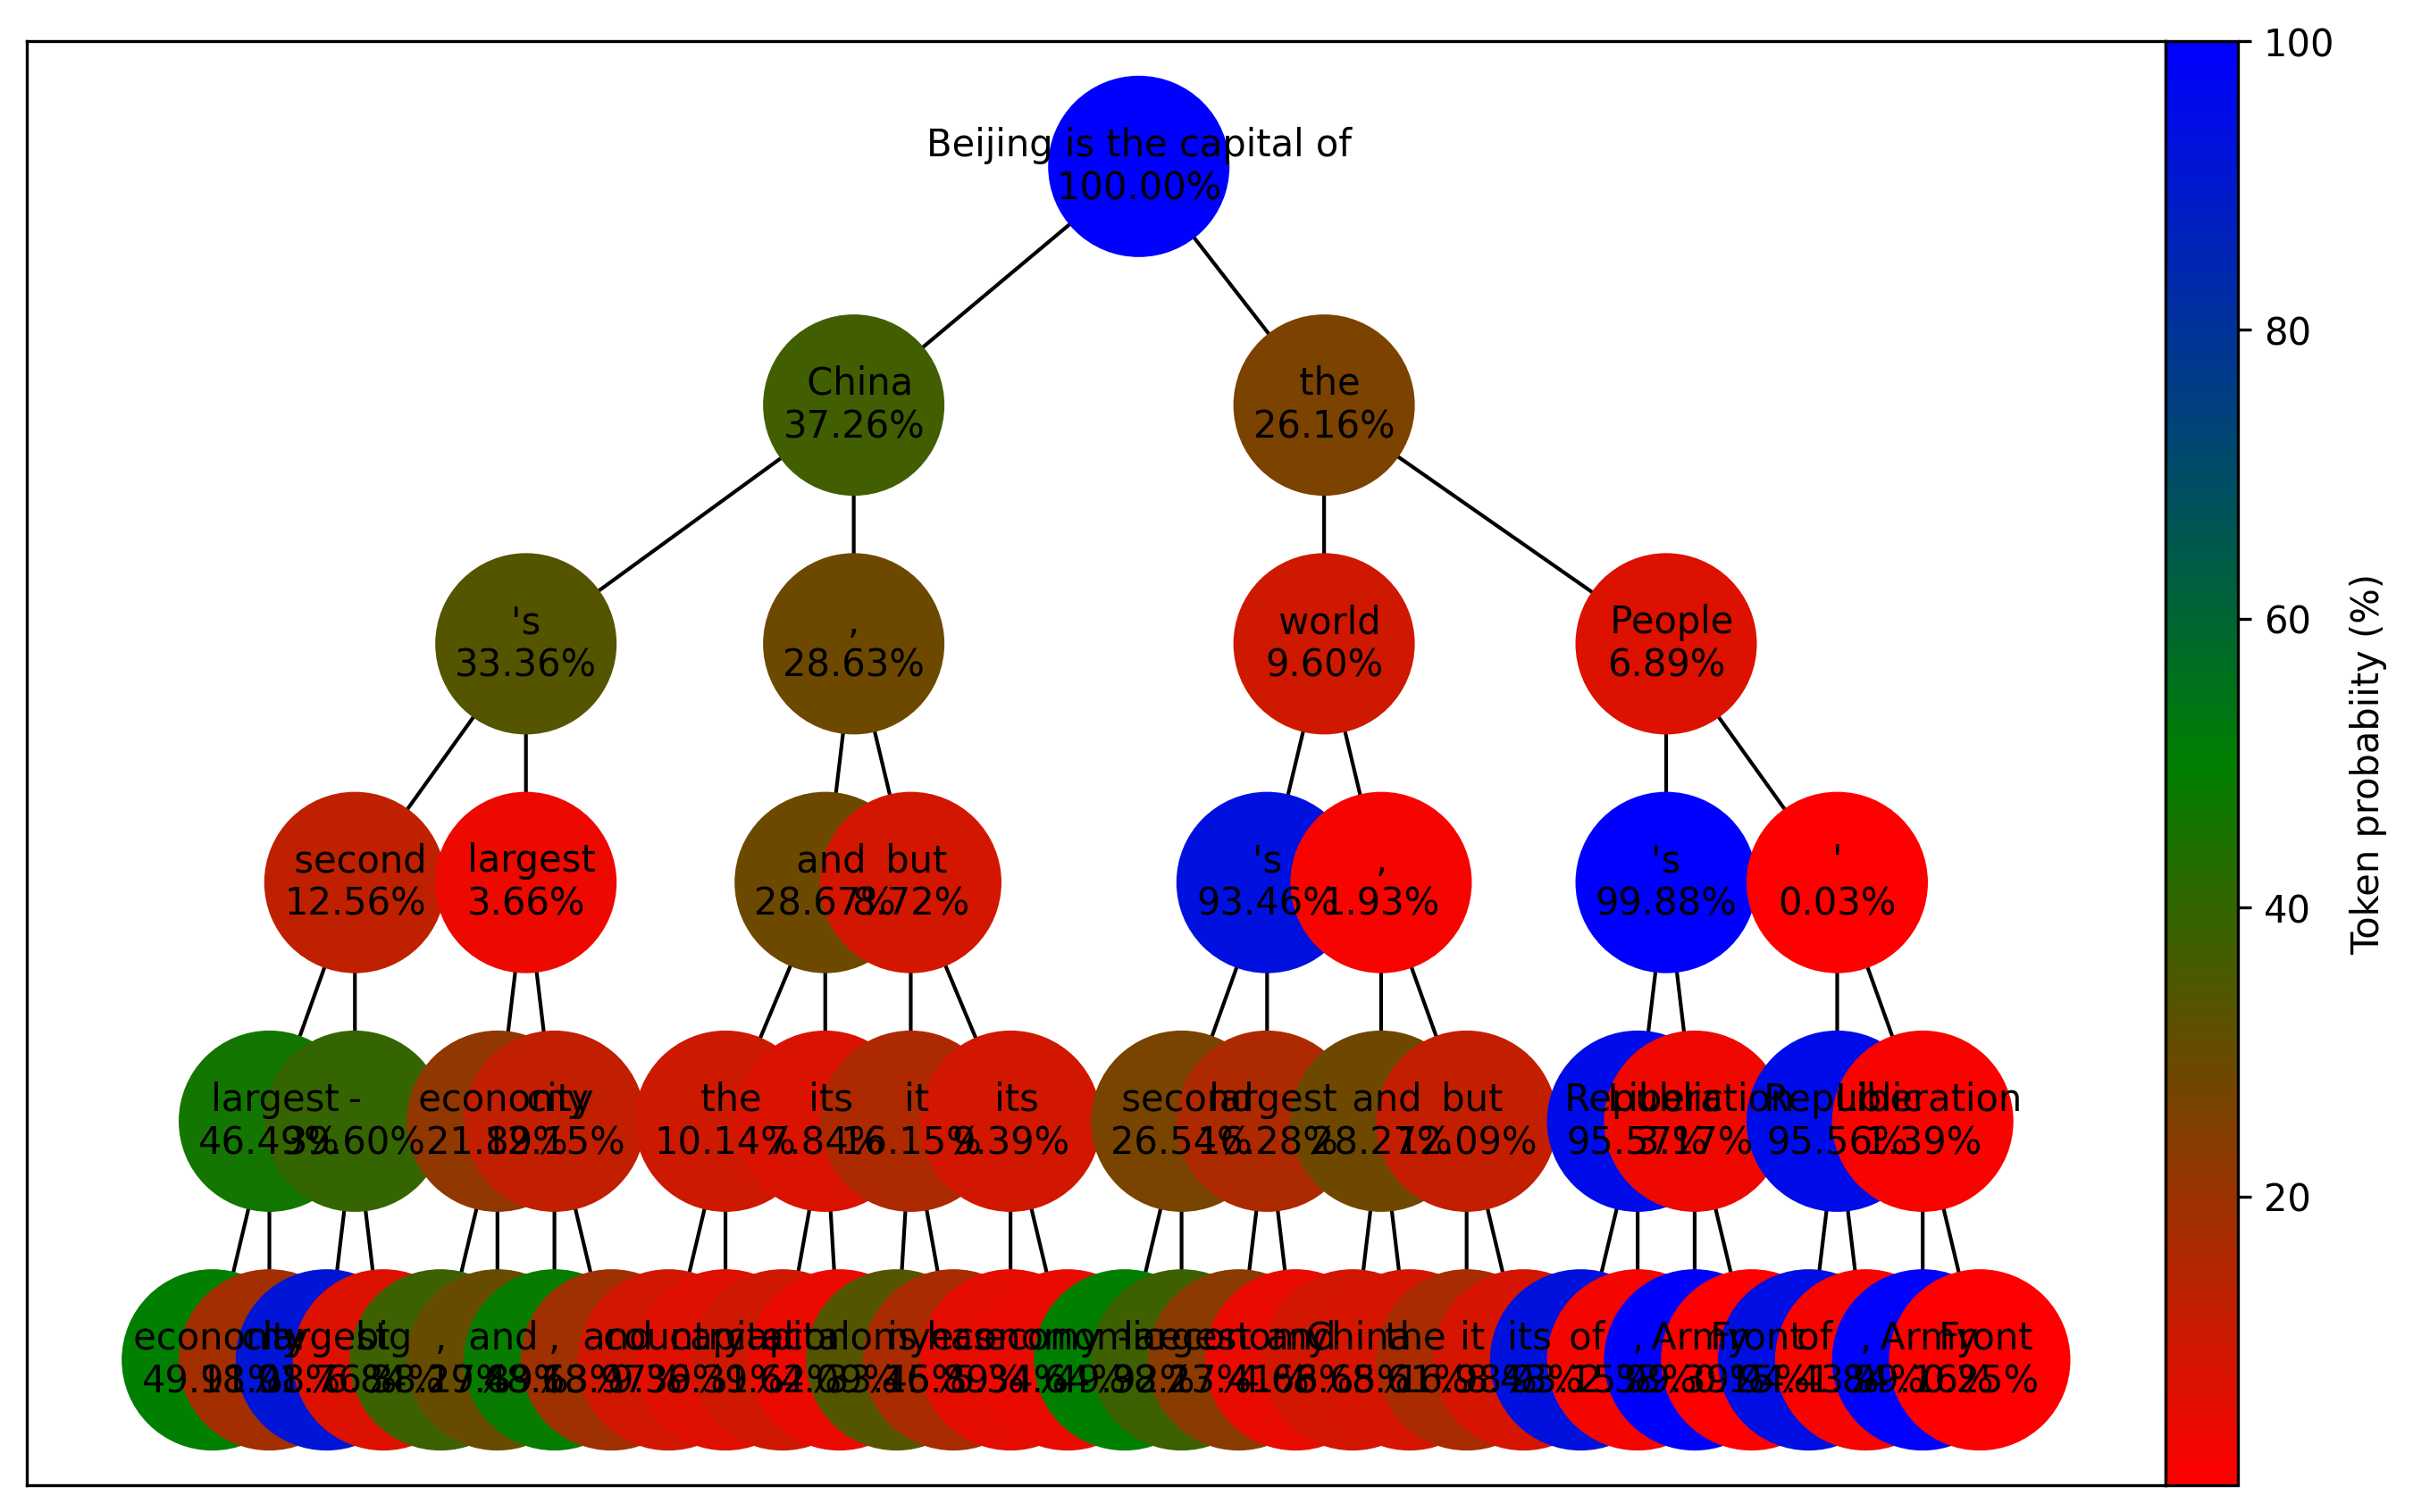

In [5]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap


def plot_graph(graph, length, beams, score):
    fig, ax = plt.subplots(figsize=(3 + 1.2 * beams ** length, max(5, 2 + length)), dpi=300, facecolor='white')
    pos = nx.nx_agraph.graphviz_layout(graph, prog='dot')
    if score == 'token':
        scores = [data['tokenscore'] for _, data in graph.nodes(data=True) if data['token'] is not None]
    elif score == 'sequence':
        scores = [data['sequencesore'] for _, data in graph.nodes(data=True) if data['token'] is not None]
    vmin = min(scores)
    vmax = max(scores)
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    cmap = LinearSegmentedColormap.from_list('rg', ['r', 'g', 'b'], N=256)
    # 绘制节点
    nx.draw_networkx_nodes(graph, pos, node_size=2000, node_shape='o', alpha=1, linewidths=4, node_color=scores, cmap=cmap)
    # 绘制边
    nx.draw_networkx_edges(graph, pos)
    # 绘制标签
    if score == 'token':
        labels = {node: data['token'].split('_')[0] + f"\n{data['tokenscore']:.2f}%" for node, data in graph.nodes(data=True) if data['token'] is not None}
    elif score == 'sequence':
        labels = {node: data['token'].split('_')[0] + f"\n{data['sequencesore']:.2f}%" for node, data in graph.nodes(data=True) if data['token'] is not None}
    nx.draw_networkx_labels(graph, pos, labels=labels, font_size=10)
    # 绘制颜色条
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    if score == 'token':
        cbar = plt.colorbar(sm, ax=ax, orientation='vertical', pad=0, label='Token probabiity (%)')
    elif score =='sequence':
        cbar = plt.colorbar(sm, ax=ax, orientation='vertical', pad=0, label='Sequence score')
    plt.show()

plot_graph(graph, length, 1.5, 'token')